In [15]:
import os

In [16]:
%pwd

'c:\\Users\\zainulabideen\\Desktop\\Chest_Cancer_Classification_Mlflow_and_DVC'

In [17]:
directory_path = r"C:\Users\zainulabideen\Desktop\Chest_Cancer_Classification_Mlflow_and_DVC\research"
os.chdir(directory_path)

In [18]:
%pwd

'C:\\Users\\zainulabideen\\Desktop\\Chest_Cancer_Classification_Mlflow_and_DVC\\research'

In [19]:
os.chdir('../')
%pwd

'C:\\Users\\zainulabideen\\Desktop\\Chest_Cancer_Classification_Mlflow_and_DVC'

In [29]:
from Cnn_Chest_Cancer_Classification.constants import *
from Cnn_Chest_Cancer_Classification.utils.common import read_yaml , create_directories
from Cnn_Chest_Cancer_Classification.entity.config_entity import DataIngestionConfig
import os
class ConfigurationManager:
    def __init__( self,config_filepath = CONFIG_FILE_PATH, params_filepath = PARAMS_FILE_PATH):
            self.config =read_yaml(config_filepath)
            self.params = read_yaml(params_filepath)

            create_directories([self.config.artifacts_root])
        
    def get_data_ingestion_config(self) -> DataIngestionConfig:
          config = self.config.data_ingestion
          create_directories([config.root_dir])

          data_ingestion_config = DataIngestionConfig(
                root_dir=config.root_dir,
                source_URL=config.source_URL,
                local_data_file=config.local_data_file,
                unzip_dir=config.unzip_dir
          )
          return data_ingestion_config
    
    def get_data_directories_config(self):
            data_dirs = self.config.get("data_directories")
            base_dir = data_dirs.get("base_dir")
            train_dir = os.path.join(base_dir, data_dirs.get("train_dir"))
            valid_dir = os.path.join(base_dir, data_dirs.get("valid_dir"))
            test_dir = os.path.join(base_dir, data_dirs.get("test_dir"))
            return train_dir, valid_dir, test_dir

    


In [38]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from Cnn_Chest_Cancer_Classification.config.configuration import ConfigurationManager
from Cnn_Chest_Cancer_Classification.utils.common import visualize_images

class ImageDataLoader:
    def __init__(self, train_dir, valid_dir,  test_dir,root_dir=None , image_size=(150, 150), batch_size=32 , ):
        self.train_dir = train_dir
        self.valid_dir = valid_dir
        self.test_dir = test_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.root_dir = root_dir
        if self.root_dir:
            os.makedirs(self.root_dir, exist_ok=True)
            self.train_preprocessed_dir = os.path.join(self.root_dir, "train")
            self.valid_preprocessed_dir = os.path.join(self.root_dir, "valid")
            os.makedirs(self.train_preprocessed_dir, exist_ok=True)
            os.makedirs(self.valid_preprocessed_dir, exist_ok=True)

    def get_image_data_generators(self, augmentation=True, shuffle=True):
        train_generator = self._create_image_generator(self.train_dir,self.train_preprocessed_dir, augmentation, shuffle)
        valid_generator = self._create_image_generator(self.valid_dir,self.valid_preprocessed_dir, False, shuffle)
        test_generator = self._create_image_generator(self.test_dir, None,False, shuffle=False)
        return train_generator, valid_generator, test_generator

    def _create_image_generator(self, directory,save_dir, augmentation, shuffle):
        # config_manager = ConfigurationManager()
        # preprocessing_config = config_manager.config['data_preprocessing']
        # preprocessed_images_dir = preprocessing_config['root_dir']
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=5 if augmentation else 0,
            width_shift_range=0.2 if augmentation else 0,
            height_shift_range=0.2 if augmentation else 0,
            shear_range=0.2 if augmentation else 0,
            zoom_range=0.2 if augmentation else 0,
            horizontal_flip=True if augmentation else False,
            vertical_flip=True if augmentation else False,
            fill_mode='nearest'
        )
        save_dir = self.root_dir if self.root_dir else None

        return datagen.flow_from_directory(
            directory,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='categorical' if directory != self.test_dir else None,
            shuffle=shuffle,
            save_to_dir=save_dir,  # Specify the directory to save preprocessed images
            save_prefix='preprocessed_',  # Prefix for saved images
            save_format='png'
        )







In [ ]:
try:
    config2 = ConfigurationManager()
    root_dir = config2.config.get("data_preprocessing").get("root_dir", None)
    data_dirs = config2.get_data_directories_config()
    preprocessed_data= ImageDataLoader(*data_dirs , root_dir=root_dir) #Passing *data_directories allows you to unpack the tuple data_directories and pass its elements as individual arguments to the ImageDataLoader constructor. data_directories = ("path/to/train", "path/to/valid", "path/to/test")  data_loader = ImageDataLoader(base_dir, *data_directories)
    train_generator, valid_generator, test_generator = preprocessed_data.get_image_data_generators()
    visualize_images(train_generator)
except Exception as e:
    raise e

In [11]:
import os
from Cnn_Chest_Cancer_Classification.utils.common import visualize_images
import tensorflow as tf





class ImageDataLoader:
    def __init__(self, train_dir, valid_dir, test_dir, image_size=(150, 150), batch_size=32):
        self.train_dir = train_dir
        self.valid_dir = valid_dir
        self.test_dir = test_dir
        self.image_size = image_size
        self.batch_size = batch_size

    def get_image_data_generators(self, augmentation=True, shuffle=True):
        train_generator = self._create_image_generator(self.train_dir, augmentation, shuffle)
        valid_generator = self._create_image_generator(self.valid_dir, False, shuffle)
        test_generator = self._create_image_generator(self.test_dir, False, shuffle=False)
        return train_generator, valid_generator, test_generator

    def _create_image_generator(self, directory, augmentation, shuffle):
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=5 if augmentation else 0,
            width_shift_range=0.2 if augmentation else 0,
            height_shift_range=0.2 if augmentation else 0,
            shear_range=0.2 if augmentation else 0,
            zoom_range=0.2 if augmentation else 0,
            horizontal_flip=True if augmentation else False,
            vertical_flip=True if augmentation else False,
            fill_mode='nearest'
        )
        return datagen.flow_from_directory(
            directory,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='categorical' if directory != self.test_dir else None,
            shuffle=shuffle
        )










In [ ]:
try:
    config = ConfigurationManager()
    data_dirs = config.get_data_directories_config()
    preprocessed_data= ImageDataLoader(*data_dirs) #Passing *data_directories allows you to unpack the tuple data_directories and pass its elements as individual arguments to the ImageDataLoader constructor. data_directories = ("path/to/train", "path/to/valid", "path/to/test")  data_loader = ImageDataLoader(base_dir, *data_directories)
    train_generator, valid_generator, test_generator = preprocessed_data.get_image_data_generators()
    visualize_images(train_generator)
except Exception as e:
    raise e

[2024-03-14 19:31:23,940: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-03-14 19:31:23,942: INFO: common: yaml file: params.yaml loaded successfully]
[2024-03-14 19:31:23,943: INFO: common: created directory at: artifacts]
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


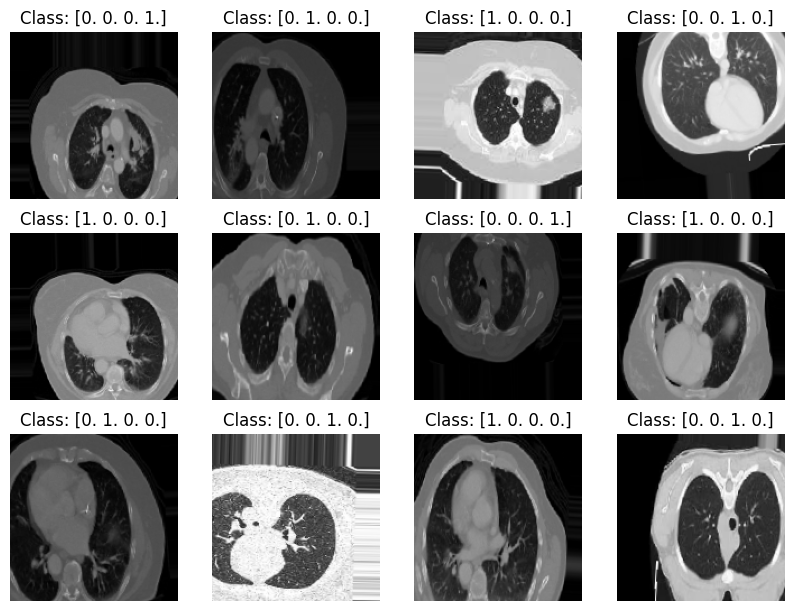